<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

***

In [1]:
import os

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

from sklearn.metrics import mean_absolute_error as mae

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
# !pip install missingno

In [3]:
import missingno as msno

## Подготовка данных

In [4]:
def get_data(filename):
    
    """
    Reads the data from the given path.
    """

    pth1 = f'/datasets/{filename}'
    pth2 = f'data/{filename}'

    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
        print(f'Reading {pth1}...')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2)
        print(f'Reading {pth2}...')
    else:
        print('Check the file path')

    return df

In [5]:
full_df = get_data('gold_recovery_full_new.csv')
test_df = get_data('gold_recovery_test_new.csv')
train_df = get_data('gold_recovery_train_new.csv')

Reading data/gold_recovery_full_new.csv...
Reading data/gold_recovery_test_new.csv...
Reading data/gold_recovery_train_new.csv...


### Проверка рассчета эффективности обогощения

### $\text{Recovery} = \frac{C \times (F - T)}{F \times (C - T)}$

In [6]:
C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

recovery = (C * (F - T)) / (F * (C - T)) * 100

In [7]:
train_recovery_mae = mae(recovery, train_df['rougher.output.recovery'])

print(f'rougher.output.recovery check: MAE = {train_recovery_mae:.2e}')

if train_recovery_mae < 1e-5:
    print('rougher.output.recovery check: PASSED')

rougher.output.recovery check: MAE = 9.74e-15
rougher.output.recovery check: PASSED


> Эффективность обогощения рассчитана корректно

### Состав признаков

In [8]:
train_minus_test_cols = set(train_df.columns) - set(test_df.columns)

train_df[train_minus_test_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   primary_cleaner.output.concentrate_ag               14149 non-null  float64
 1   primary_cleaner.output.concentrate_pb               14063 non-null  float64
 2   primary_cleaner.output.tail_sol                     14103 non-null  float64
 3   rougher.calculation.sulfate_to_au_concentrate       14148 non-null  float64
 4   secondary_cleaner.output.tail_sol                   12544 non-null  float64
 5   rougher.output.concentrate_sol                      14127 non-null  float64
 6   secondary_cleaner.output.tail_pb                    14139 non-null  float64
 7   secondary_cleaner.output.tail_ag                    14147 non-null  float64
 8   final.output.tail_pb                                14049 non-null  float64


/var/folders/nc/53ydtkz56jj83586jxv6mvlm0000gn/T/ipykernel_26463/84675947.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df[train_minus_test_cols].info()


In [9]:
types = []

for col in train_minus_test_cols:
    
    parameter_type = col.split('.')[1]
    if parameter_type not in types:
        types.append(parameter_type)

print(f'Feature types not in the test dataset: {types}')

Feature types not in the test dataset: ['output', 'calculation']


In [10]:
print(f'Number of features in the train dataset: {len(train_df.columns)}')
train_df = train_df.drop(columns=train_minus_test_cols)
print(f'Number of features in the train dataset: {len(train_df.columns)}')

Number of features in the train dataset: 87
Number of features in the train dataset: 53


> В тестовом датасете отсутствуют некоторые расчетные характеристики и параметры продукта


> Из тренировочного датасета были исключены колонки, отсутствующие в тестовой выборке

### Заполнение пропусков

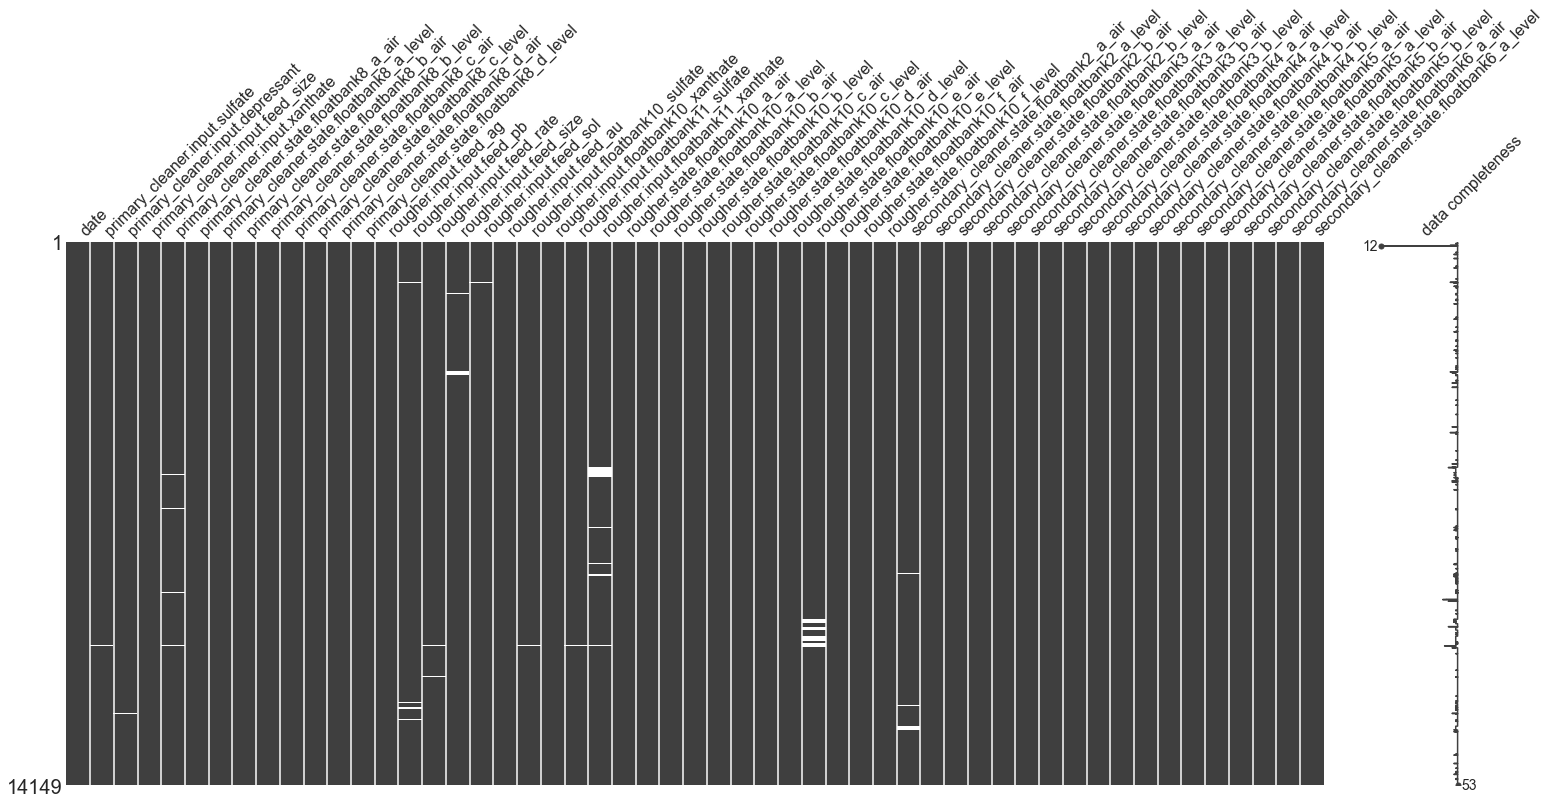

In [11]:
msno.matrix(train_df, labels=True, figsize=(25, 10))
plt.show()

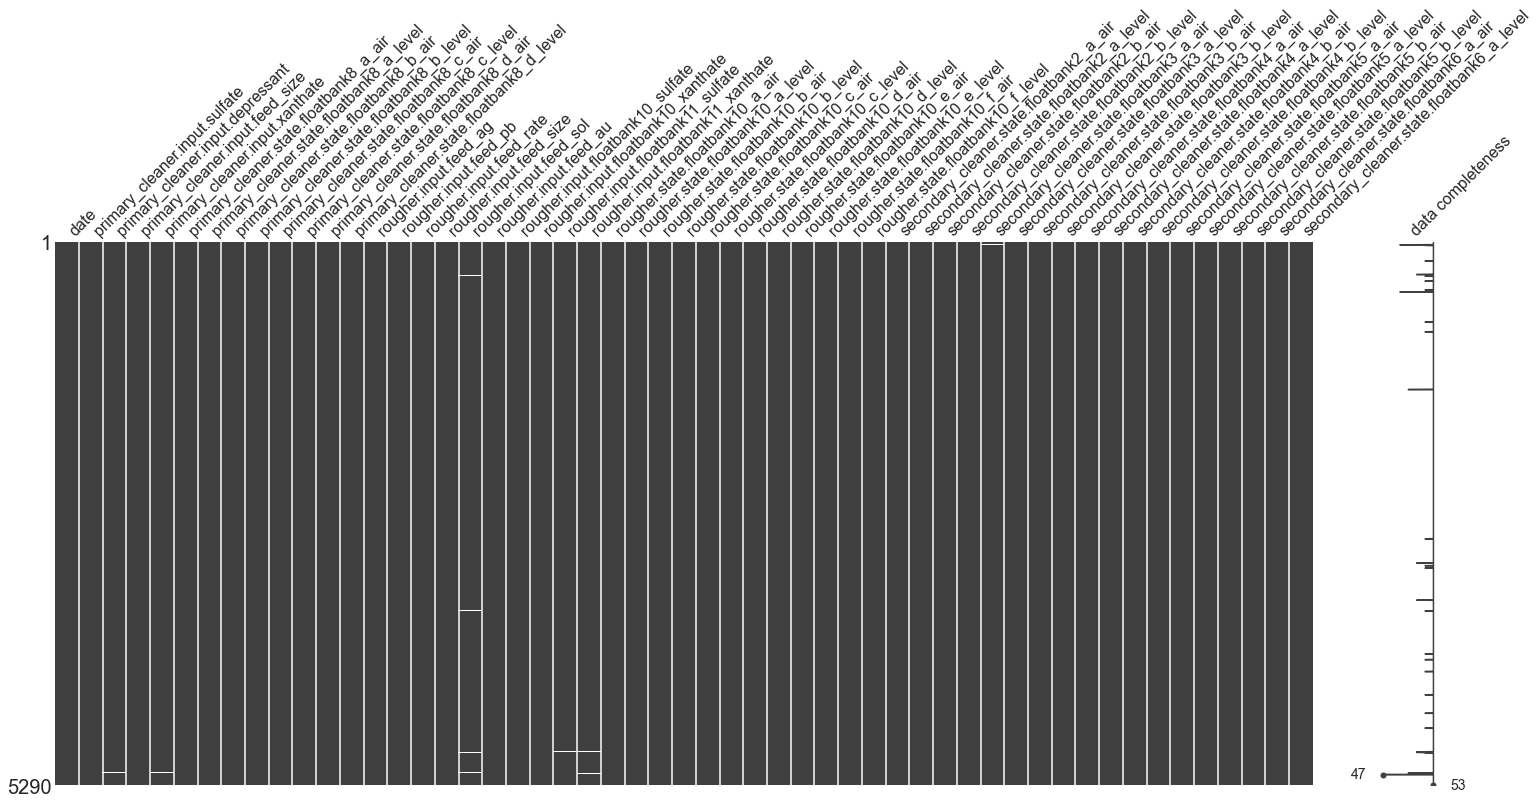

In [12]:
msno.matrix(test_df, labels=True, figsize=(25, 10))
plt.show()

In [13]:
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

print(f'Number of missing values in the train dataset: {train_df.isna().sum().sum()}')
print(f'Number of missing values in the test dataset: {test_df.isna().sum().sum()}')

Number of missing values in the train dataset: 0
Number of missing values in the test dataset: 0


> Пропуски заполнены методом fill forward, так как `Соседние по времени параметры часто похожи.`

#### Проверка на наличие мультиколлинеарных признаков

In [99]:
train_df.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

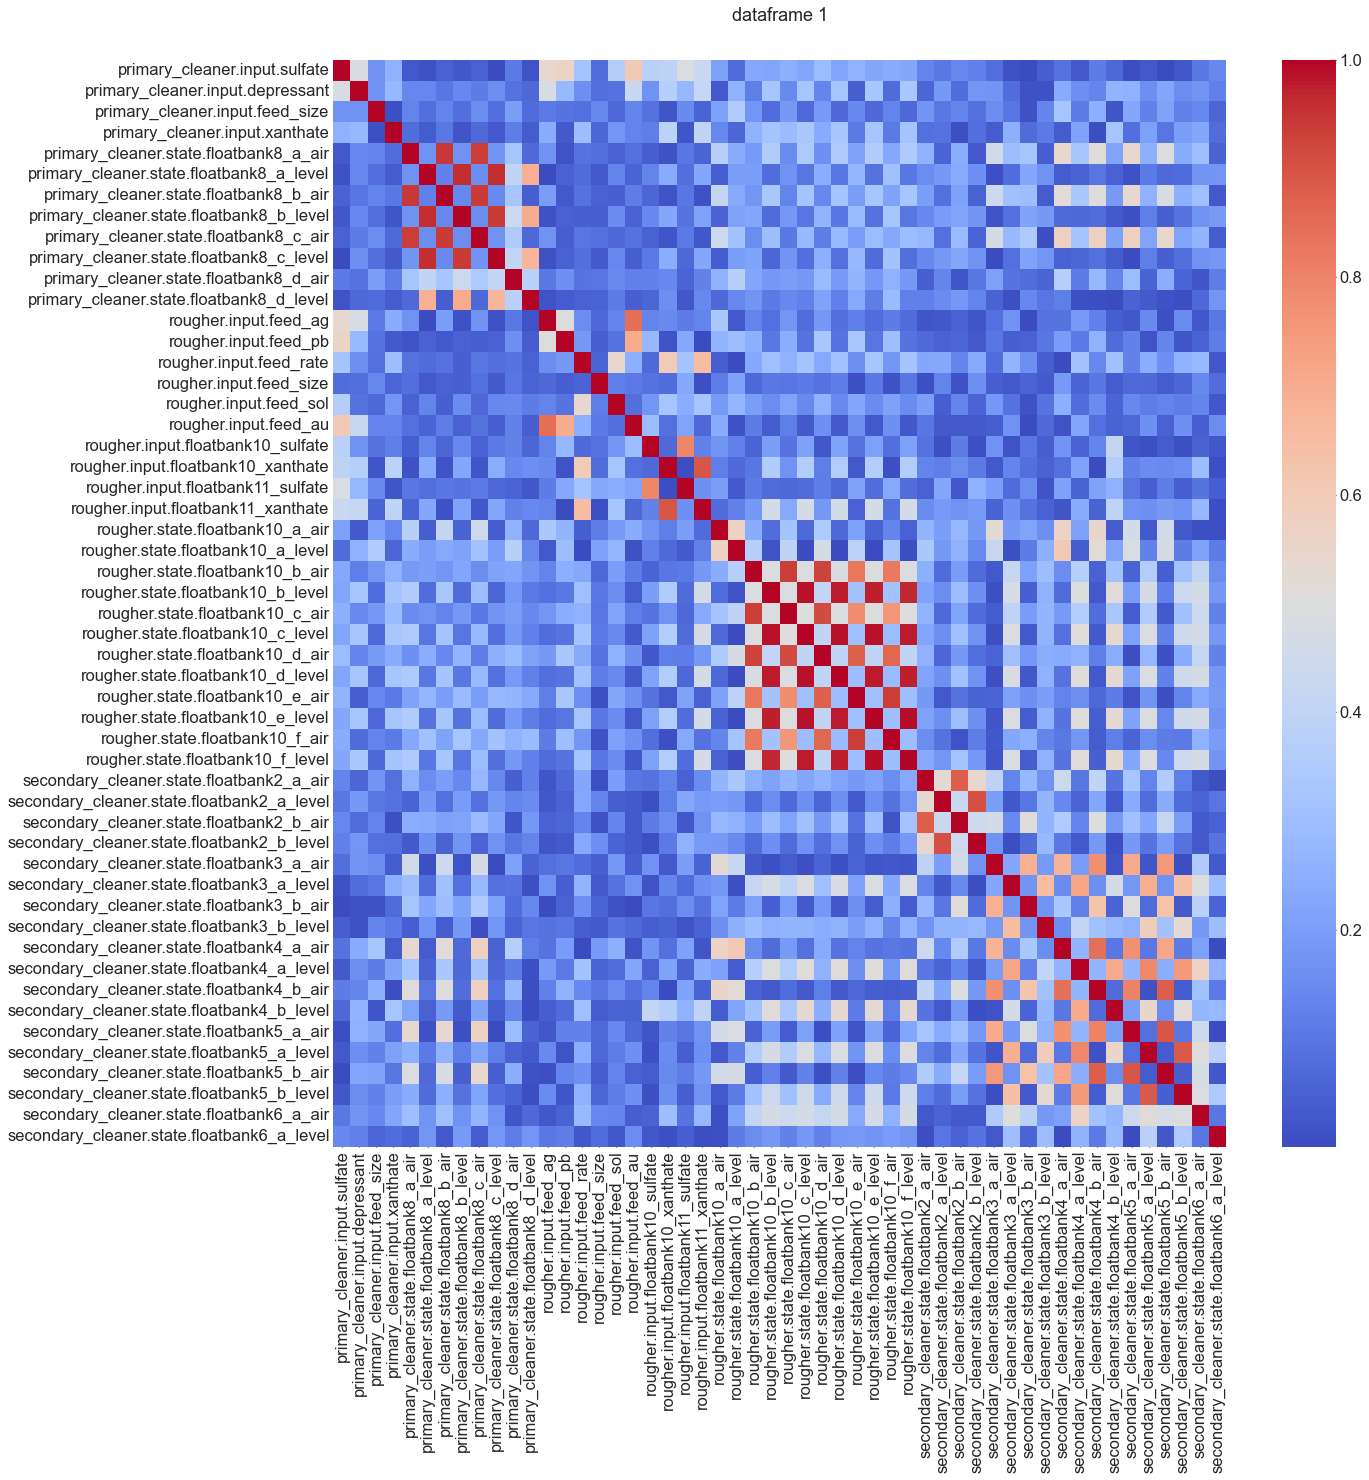

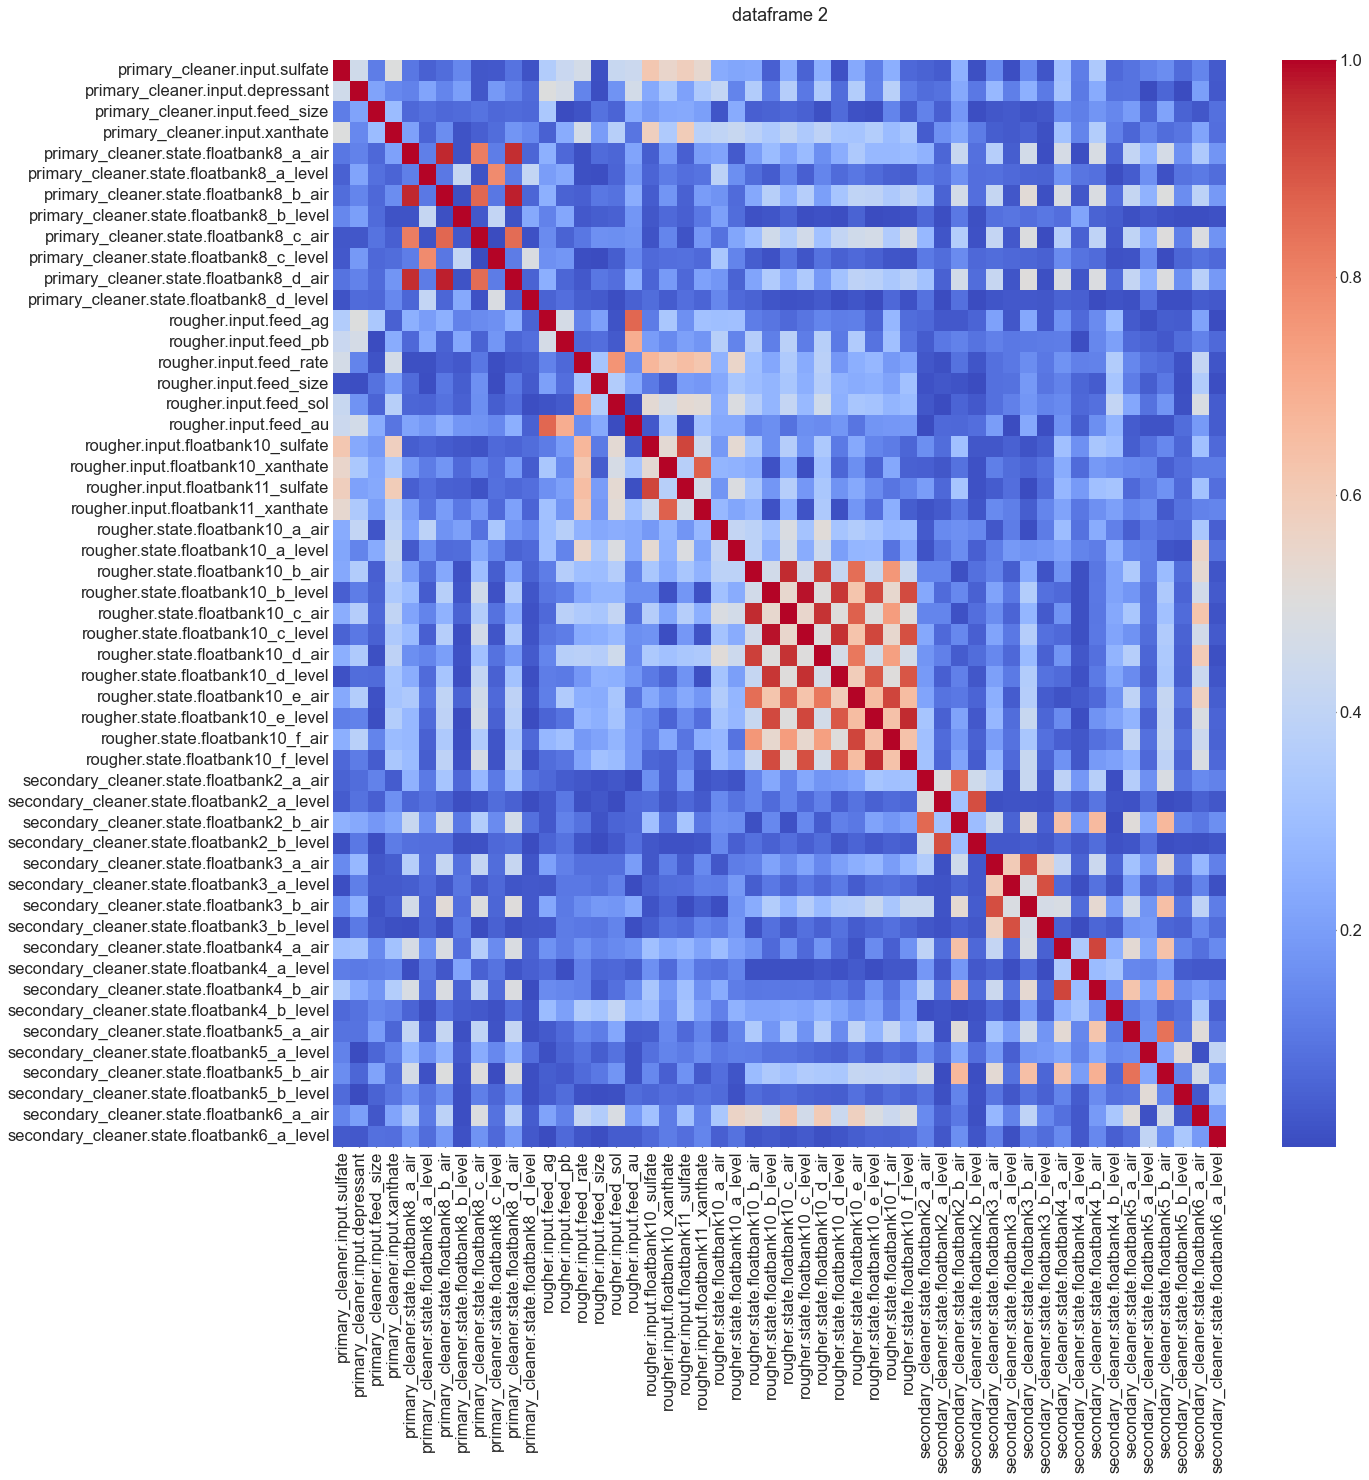

In [104]:
i = 1

for df in [train_df, test_df]:
    fig, ax = plt.subplots(figsize=(20, 20))
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax)
    ax.set_title(f'dataframe {i}', y=1.03)

    i += 1

In [96]:
len(train_df.columns)

53

<AxesSubplot:>

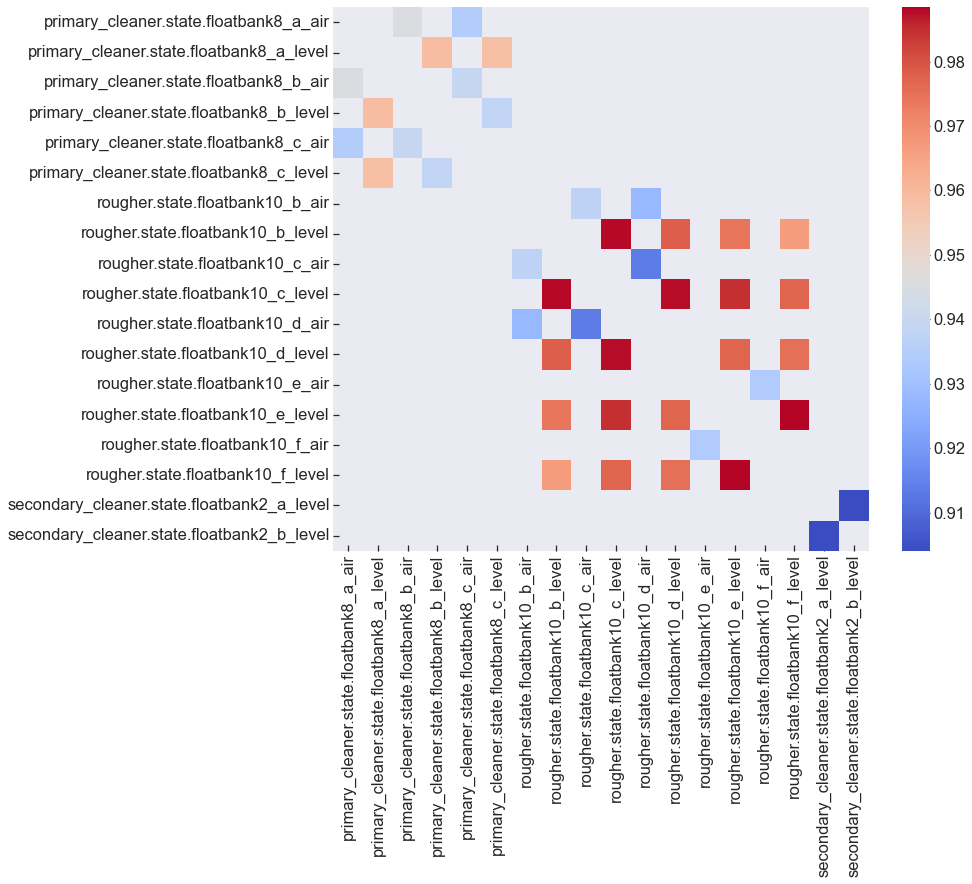

In [127]:
fig, ax = plt.subplots(figsize=(12, 10))

df = train_df

# Create correlation matrix
corr_matrix = df.corr().abs()

overcorr_matrix = corr_matrix[(corr_matrix > .9) & (corr_matrix < 1)]
overcorr_matrix = overcorr_matrix.dropna(how='all', axis=0)
overcorr_matrix = overcorr_matrix.dropna(how='all', axis=1)

sns.heatmap(overcorr_matrix, annot=False, cmap='coolwarm', ax=ax, fmt='.2f')

# to_drop = [column for column in overcorr_matrix.columns if overcorr_matrix[column].isna().sum() != 0]

# to_drop

## Анализ данных

## Модель

In [120]:
list(full_df)

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке